<div style="text-align:center; border: 1px solid #808080; padding: 10px;">
  <h1 style="color: gray; font-weight: bold;">Credit Card Predictive Analysis | EDA:</h1>
  <h2 style="color: gray; font-weight: bold;">Credit Risk Classification Using  Model of Best Fit</h2>
</div>

## Problem Statement

- Credit score cards are used in the financial industry to predict the likelihood of credit card defaults and guide the issuance of credit cards. These scores rely on applicants' personal data and historical information, quantifying risk objectively.
- **Project Goal**:
>- The primary objective of this project is to **build a predictive model** that accurately identifies whether a customer is **high-risk** for credit card approval, enabling data-driven decision-making in the credit screening process.

## Huggingface model samples


- aegishield/credit_card_purchase_prediction
- timhbach/Team-Gryffindor-DistilBERT-finetuned-ner-creditcardcontract
- PabitraJiban/Credit-card-collection-intent-classification

## Load libraries & helpers

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from autoviz import AutoViz_Class
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import pickle
import joblib


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [1]:
# Set up the project path
import os, sys
from pathlib import Path
from IPython.display import display, Image 
sys.path.append("../../scripts")

from preprocessor import *
from predict_risk import *
from data_processing_framework import *

## Data load & understanding

In [4]:
path = "rikdifos/credit-card-approval-prediction"
result = fetch_kaggle_dataset_by_path(path, temp_dir=".temp_kaggle")

📦 Fetching Kaggle dataset: rikdifos/credit-card-approval-prediction
Dataset URL: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction


Dropdown(description='Select File:', options=('application_record.csv', 'credit_record.csv'), value='applicati…

Button(description='📥 Load Selected File', style=ButtonStyle())

Output()

🔄 Select a file to load individually. You can rerun to load others.


In [9]:
# load dataset 1
appl_df = raw_df
appl_df.columns
appl_df.to_csv("appl.csv")

In [10]:
# load dataset 2
credits_df = raw_df
credits_df.columns
credits_df.to_csv("crdt.csv")

---
*Credit df:*
> 1048575 entries, Data columns (total 3 columns)

*Application df:*
> 438557 entries , Data columns (total 18 columns)


| Feature Name    | Explanation     | Remarks                                                                                       |
|-----------------|-----------------|-----------------------------------------------------------------------------------------------|
| MONTHS_BALANCE  | Record month    | The month of the extracted data is the starting point, backwards, `0 is the current month`, `-1 is the previous month`, and so on |
| STATUS          | Status          | `0: 1-29 days past due` `1: 30-59 days past due` `2: 60-89 days overdue` `3: 90-119 days overdue` `4: 120-149 days overdue` `5: Overdue or bad debts, write-offs for more than 150 days` `C: paid off that month` `X: No loan for the month` |

---

## Creating the target variable (is_high_risk)

---
To create the target column Is_high_risk (binary: 1 for risky, 0 for not risky),

- Step 1: Define Risky Statuses: Based on the STATUS column, classify customers as "risky" if they have ever had a severe delinquency (e.g., 30+ days overdue). Common thresholds include:
- > STATUS = 1, 2, 3, 4, or 5 (60+ days past due).

- Step 2: Aggregate Customer Behavior: Group the data by ID and check if the customer has any risky status in their history:
- I will merge the two dataframes based on the `ID` column, using the `inner` parameter in the `pd.merge` function.
- ---

In [21]:
# Calculate account age and target variable:is_high_risk
# Group by ID and find the earliest (most negative) months_balance
account_age = credits_df.groupby('ID')['MONTHS_BALANCE'].min().abs()

# Define the severity order of statuses and create target variable
status_severity = {
    '5': 7,  # Most severe - Overdue >150 days
    '4': 6,  # 120-149 days overdue
    '3': 5,  # 90-119 days overdue
    '2': 4,  # 60-89 days overdue
    '1': 3,  # 30-59 days past due
    '0': 2,  # 1-29 days past due
    'C': 1,  # Paid off
    'X': 0   # No loan
}

target_df =credits_df.copy()

# Sort by ID and months_balance (descending to get most recent first)
target_df = target_df.sort_values(['ID', 'MONTHS_BALANCE'], ascending=[True, False])

# Keep only the most recent record for each ID
target_df = target_df.drop_duplicates(subset=['ID'], keep='first')

# Create is_high_risk based on the most recent status
target_df['is_high_risk'] = target_df['STATUS'].isin(['1','2','3', '4', '5']).astype(int)
target_df['account_age_months'] = target_df['ID'].map(account_age)
target_df = target_df[['ID', 'account_age_months','is_high_risk']]

target_df

,ID,account_age_months,is_high_risk
0,5001711,3,0
4,5001712,18,0
23,5001713,21,0
45,5001714,14,0
60,5001715,59,0
...,...,...,...
1048494,5150482,28,0
1048512,5150483,17,0
1048530,5150484,12,0
1048543,5150485,1,0


In [22]:
# Merge target variable (credits_df)  with latest application data
merged_df = appl_df.merge(target_df, on='ID', how='inner')
display(merged_df.head())
for col in merged_df.columns:
    print(f"{col}: {merged_df[col].unique()}")

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,account_age_months,is_high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


ID: [5008804 5008805 5008806 ... 5149838 5150049 5150337]
CODE_GENDER: ['M' 'F']
FLAG_OWN_CAR: ['Y' 'N']
FLAG_OWN_REALTY: ['Y' 'N']
CNT_CHILDREN: [ 0  1  3  2  4  5 14 19  7]
AMT_INCOME_TOTAL: [ 427500.   112500.   270000.   283500.   135000.   130500.   157500.
  405000.   211500.   360000.   126000.   315000.   247500.   297000.
  225000.   166500.   216000.   255150.   148500.   202500.    94500.
  450000.   180000.    90000.   765000.   382500.   144000.   229500.
  292500.    74250.    40500.   337500.   193500.   267750.   139500.
   67500.   252000.   900000.   115290.   279000.    76500.   234000.
   81000.   108000.    99000.   198000.    45000.   238500.   117000.
  153000.  1350000.   445500.   495000.    85500.   306000.   562500.
  189000.   328500.   310500.   540000.   171000.   675000.   121500.
   72000.    65250.   184500.   103500.   162000.   165150.    54000.
  243000.   256500.    33300.   697500.   101250.    58500.   110250.
  472500.   196650.   630000.   43200

**Column Description of Merged Dataset:**

| Feature Name        | Explanation                  | Remarks                                                  |
|---------------------|------------------------------|----------------------------------------------------------|
| ID                  | Client number                |                                                          |
| CODE_GENDER         | Gender                       |                                                          |
| FLAG_OWN_CAR        | Is there a car               |                                                          |
| FLAG_OWN_REALTY     | Is there a property          |                                                          |
| CNT_CHILDREN        | Number of children           |                                                          |
| AMT_INCOME_TOTAL    | Annual income                |                                                          |
| NAME_INCOME_TYPE    | Income category              |                                                          |
| NAME_EDUCATION_TYPE | Education level              |                                                          |
| NAME_FAMILY_STATUS  | Marital status               |                                                          |
| NAME_HOUSING_TYPE   | Way of living (House Type)                |                                                          |
| DAYS_BIRTH          | Birthday                     | Count backwards from current day (0), -1 means yesterday |
| DAYS_EMPLOYED       | Start date of employment     | Count backwards from current day(0). If positive, it means the person is currently unemployed. |
| FLAG_MOBIL          | Is there a mobile phone      |                                                          |
| FLAG_WORK_PHONE     | Is there a work phone        |                                                          |
| FLAG_PHONE          | Is there a phone             |                                                          |
| FLAG_EMAIL          | Is there an email            |                                                          |
| OCCUPATION_TYPE     | Occupation                   |                                                          |
| CNT_FAM_MEMBERS     | Family size                  |                                                          |


## Initial EDA / Data Quality Checks

### EDA report using ydata_profiling

In [ ]:
# EDA report using ydata_profiling
profile = ProfileReport(merged_df, title="Credit Card Approval EDA", explorative=True)
#profile.to_file("reports_html\Credit_Card_Approval_eda_report.html")
profile.to_notebook_iframe()

### Autoviz report with target variable

In [ ]:
# Autoviz report with target variable
%matplotlib inline
AV = AutoViz_Class()
dfte = AV.AutoViz(
    filename="", 
    dfte=merged_df,        
    depVar='is_high_risk'  
)

### Initial EDA Summary 

*Project Goal (Recap)*

> Build a predictive model to identify **high-risk** customers for credit card approval

- **Initial EDA Summary**

| **Summary**                                      | **Implication**                                                                 | **Proposed Preprocessing**                                                                 |
|--------------------------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| Target variable is imbalanced                   | Model may be biased towards the majority class                                  | Apply resampling techniques (SMOTE/undersampling), or use class weights in model training |
| Some numeric features are skewed (e.g., income) | Skewed distributions can affect model performance and assumptions               | Apply log or Box-Cox transformation to normalize distributions                            |
| Outliers present in numeric features            | Outliers can distort model training and metrics                                 | Detect and treat outliers using IQR, Z-score, or clipping                                 |
| Categorical variables show predictive patterns  | Important for model learning and interpretability                               | Encode using one-hot or target encoding depending on cardinality                          |
| Weak multicollinearity overall                  | Features are largely independent                                                | Minimal action needed, retain current features                                             |
| Some numeric features moderately correlate with target | Useful predictors identified                                                 | Prioritize these features in model; consider feature selection techniques                 |
| Visual clusters in pairwise scatter plots       | Potential for separability between classes                                      | Normalize or scale data for algorithms sensitive to feature magnitude (e.g., SVM, KNN)    |





## DQ Issues Summary Report & Data Preprocessing

- *Data Quality Table*

| **DQ Issues**                            | **Implication**                                                                 | **Suggested Action**                                                                 |
|---------------------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| `CNT_CHILDREN` has outliers and high correlation with `CNT_FAM_MEMBERS` | May distort analysis; redundancy present                             | Cap; drop one of the correlated columns `CNT_FAM_MEMBERS`                             |
| `AMT_INCOME_TOTAL` contains extreme outliers | Can skew models and mean-based stats                                             | Cap                                                             |
| Rare categories in `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_HOUSING_TYPE`, `STATUS` | Unstable model behavior due to sparse classes                        | Group categories                                                       |
| `DAYS_EMPLOYED` has significant outliers     | Unrealistic values may affect time-based models                                 | Cap                               |
| `OCCUPATION_TYPE` has missing values, rare categories, and mixed types | Incomplete and inconsistent data                                                 |drop                       |
| `CNT_FAM_MEMBERS` contains outliers          | Outliers can distort predictions                                                 | Cap                                        |
| Target class imbalance (`Is_high_risk`)      | Model may favor majority class                                                  | Apply SMOTE or class weighting                                                      |
| Skewed numeric distributions                 | Skewed features can reduce model performance                                    | Apply log or Box-Cox transformations                                                |
| Need to prepare data for modeling            | Model accuracy depends on clean input                                           | Scale features (StandardScaler or MinMaxScaler)                                     |
| Feature utility may be improved              | May increase model expressiveness                                               | Create bins (e.g., for credit metrics); generate interaction features               |
| Choice of model affects predictive power     | Some models handle imbalance and non-linearity better                           | Use tree-based models (Random Forest, XGBoost); test logistic regression as baseline |
| Performance metric choice matters            | Affects how success is measured                                                 | Optimize using AUC, recall, and precision                                           |

*In summary,*
> - Handle Rare categories, Outliers(capping), missing values in `OCCUPATION_TYPE`== drop
> - Scale features (StandardScaler/MinMaxScaler)
> - Transform skewed variables (log/Box-Cox)
> - Address class imbalance

### Data Preprocessing

In [23]:
cleaned_df = merged_df.copy()

In [24]:
# check datatypes
detect_columns(cleaned_df)

,Category,Columns,Count
0,Dates,[],0
1,Numerical,"[ID, CNT_CHILDREN, AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, account_age_months, is_high_risk]",12
2,Binary,"[CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY]",3
3,Multi-Category,"[NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE]",4
4,Irrelevant,[OCCUPATION_TYPE],1


In [25]:
# Drop redundant/ID Column
cleaned_df.drop(['OCCUPATION_TYPE','CNT_FAM_MEMBERS','ID','FLAG_MOBIL'], axis="columns", inplace=True)
display(cleaned_df.head())

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,account_age_months,is_high_risk
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,15,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,14,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,29,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,4,0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,26,0


#### Address column inconsistencies

In [26]:
# Apply lowercase and Strip extra whitespace to object (string) columns
for col in cleaned_df.select_dtypes(include='object').columns:
    cleaned_df[col] = cleaned_df[col].str.lower().str.strip()

In [27]:
# Convert days to years for better interpretability
cleaned_df['AGE_YEARS'] = ((cleaned_df['DAYS_BIRTH']).astype("Int64") / -365).astype("Int64")
cleaned_df['EMPLOYMENT_YEARS'] = cleaned_df['DAYS_EMPLOYED'].apply(
    lambda x: 0 if x > 0 else int(abs(x) / 365)) # change days of employments of retirees to 0

# Drop original columns that have been transformed or are redundant
columns_to_drop = ['DAYS_BIRTH', 'DAYS_EMPLOYED']
cleaned_df = cleaned_df.drop(columns=columns_to_drop)

# Clean and map education type
education_map = {
    'lower secondary': 'lower secondary',
    'incomplete higher': 'incomplete higher',
    'secondary / secondary special': 'secondary',
    'higher education': 'higher',
    'academic degree': 'degree'
}
cleaned_df['NAME_EDUCATION_TYPE'] = cleaned_df['NAME_EDUCATION_TYPE'].map(education_map)


# Group rare housing types and map to cleaner labels
housing_map = {
    'rented apartment': 'rented',
    'house / apartment': 'owned',
    'municipal apartment': 'municipal',
    'with parents': 'with_parents',
    'co-op apartment': 'other',
    'office apartment': 'other'
}
cleaned_df['NAME_HOUSING_TYPE'] = cleaned_df['NAME_HOUSING_TYPE'].map(housing_map)
cleaned_df.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,account_age_months,is_high_risk,AGE_YEARS,EMPLOYMENT_YEARS
0,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,15,0,32,12
1,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,14,0,32,12
2,m,y,y,0,112500.0,working,secondary,married,owned,0,0,0,29,0,58,3


In [28]:
# Rename and Reorder Columns
column_mapping = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'children_count',
    'AMT_INCOME_TOTAL': 'income',
    'NAME_INCOME_TYPE': 'employment_status',
    'NAME_EDUCATION_TYPE': 'education_level',
    'NAME_FAMILY_STATUS': 'married_status',
    'NAME_HOUSING_TYPE': 'dwelling',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'account_age_months' : 'account_age_months',
    'AGE_YEARS': 'age',
    'EMPLOYMENT_YEARS': 'employment_length'   
}
cleaned_df = cleaned_df.rename(columns=column_mapping)[list(column_mapping.values()) + ['is_high_risk']]
cleaned_df['is_high_risk'] = cleaned_df['is_high_risk'].astype("Int64")
display(cleaned_df.head(4))
display(cleaned_df.info())


,gender,own_car,own_property,children_count,income,employment_status,education_level,married_status,dwelling,work_phone,phone,email,account_age_months,age,employment_length,is_high_risk
0,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,15,32,12,0
1,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,14,32,12,0
2,m,y,y,0,112500.0,working,secondary,married,owned,0,0,0,29,58,3,0
3,f,n,y,0,270000.0,commercial associate,secondary,single / not married,owned,0,1,1,4,52,8,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              36457 non-null  object 
 1   own_car             36457 non-null  object 
 2   own_property        36457 non-null  object 
 3   children_count      36457 non-null  int64  
 4   income              36457 non-null  float64
 5   employment_status   36457 non-null  object 
 6   education_level     36457 non-null  object 
 7   married_status      36457 non-null  object 
 8   dwelling            36457 non-null  object 
 9   work_phone          36457 non-null  int64  
 10  phone               36457 non-null  int64  
 11  email               36457 non-null  int64  
 12  account_age_months  36457 non-null  int64  
 13  age                 36457 non-null  Int64  
 14  employment_length   36457 non-null  int64  
 15  is_high_risk        36457 non-null  Int64  
dtypes: I

None

In [29]:
cleaned_df.describe()

,children_count,income,work_phone,phone,email,account_age_months,age,employment_length,is_high_risk
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.0,36457.000000,36457.0
mean,0.430315,1.866857e+05,0.225526,0.294813,0.089722,26.164193,43.260334,5.614560,0.010478
std,0.742367,1.017892e+05,0.417934,0.455965,0.285787,16.501854,11.510414,6.417027,0.101826
min,0.000000,2.700000e+04,0.000000,0.000000,0.000000,0.000000,20.0,0.000000,0.0
25%,0.000000,1.215000e+05,0.000000,0.000000,0.000000,12.000000,34.0,1.000000,0.0
50%,0.000000,1.575000e+05,0.000000,0.000000,0.000000,24.000000,42.0,4.000000,0.0
75%,1.000000,2.250000e+05,0.000000,1.000000,0.000000,39.000000,53.0,8.000000,0.0
max,19.000000,1.575000e+06,1.000000,1.000000,1.000000,60.000000,68.0,43.000000,1.0


#### Handling outliers (cap)

In [30]:
# Check for outliers across all numeric columns using IQR
outlier_counts = detect_outliers_all(cleaned_df)
outlier_counts

,outlier_count
children_count,508
income,1529
account_age_months,0
age,0
employment_length,1999


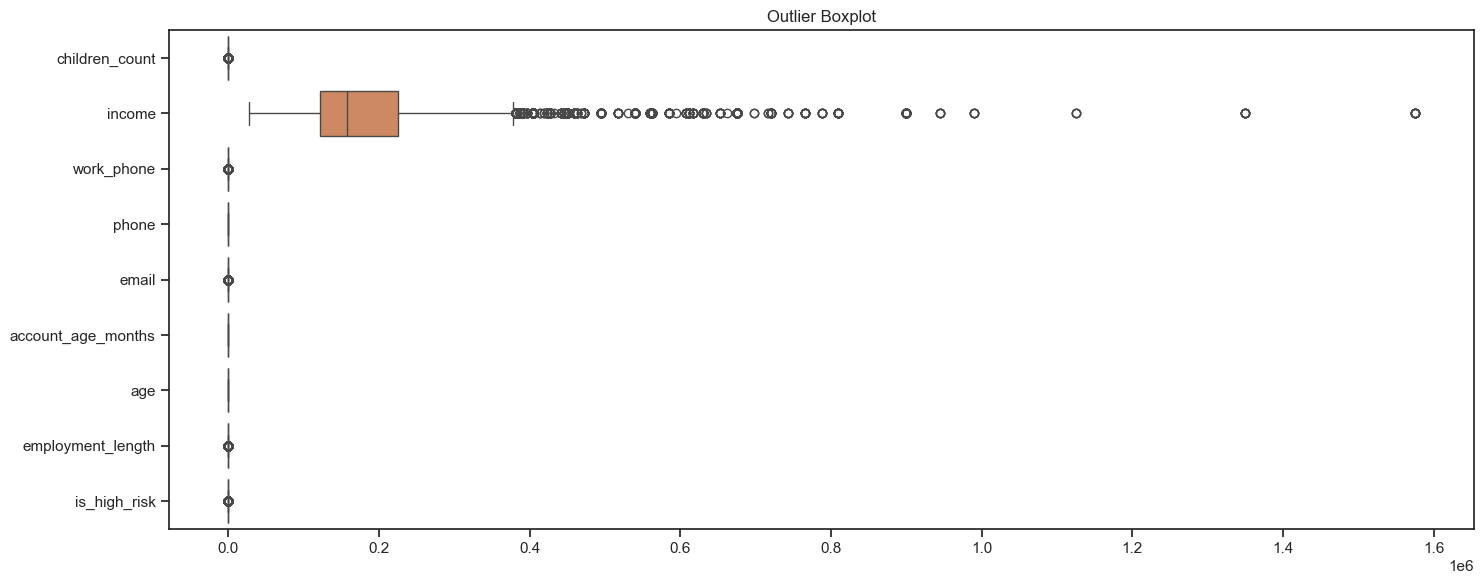

In [31]:
# plot outlier
%matplotlib inline
plot_outliers_boxplot(cleaned_df, title="Outlier Boxplot", figsize=(15, 6))

In [32]:
#cap all outliers
capped_df= cleaned_df.copy()
columns_with_outliers = outlier_counts[outlier_counts['outlier_count'] > 0].index.tolist()
columns_with_outliers

['children_count', 'income', 'employment_length']

In [33]:
for col in columns_with_outliers:
    capped_df = cap_outliers(capped_df, col)


Processing children_count for outliers...
Found 508 outliers (1.39% of data)
Lower bound: -1.50, Upper bound: 2.50
Remaining outliers after capping: 0

Processing income for outliers...
Found 1529 outliers (4.19% of data)
Lower bound: -33750.00, Upper bound: 380250.00
Remaining outliers after capping: 0

Processing employment_length for outliers...
Found 1999 outliers (5.48% of data)
Lower bound: -9.50, Upper bound: 18.50
Remaining outliers after capping: 0


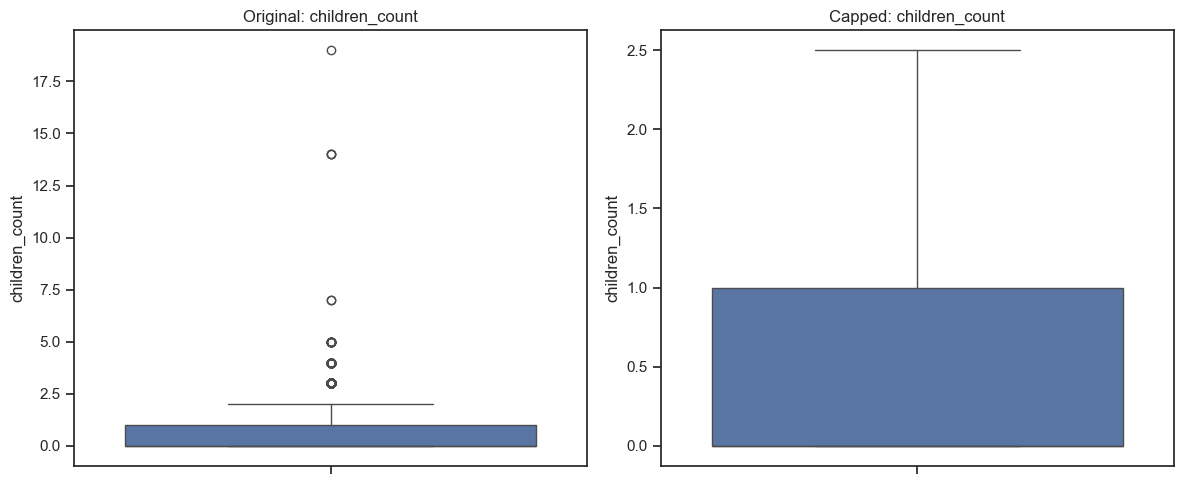

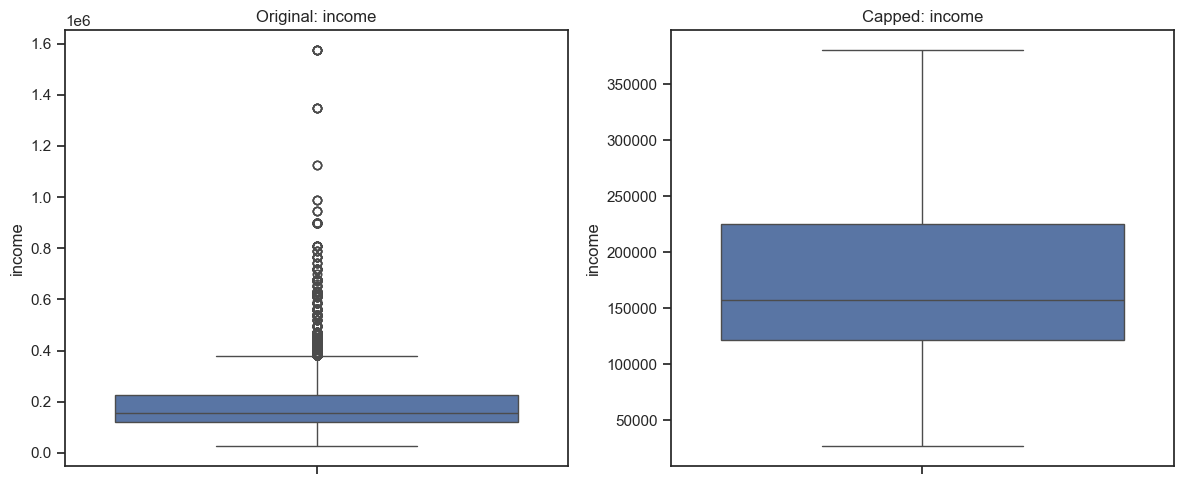

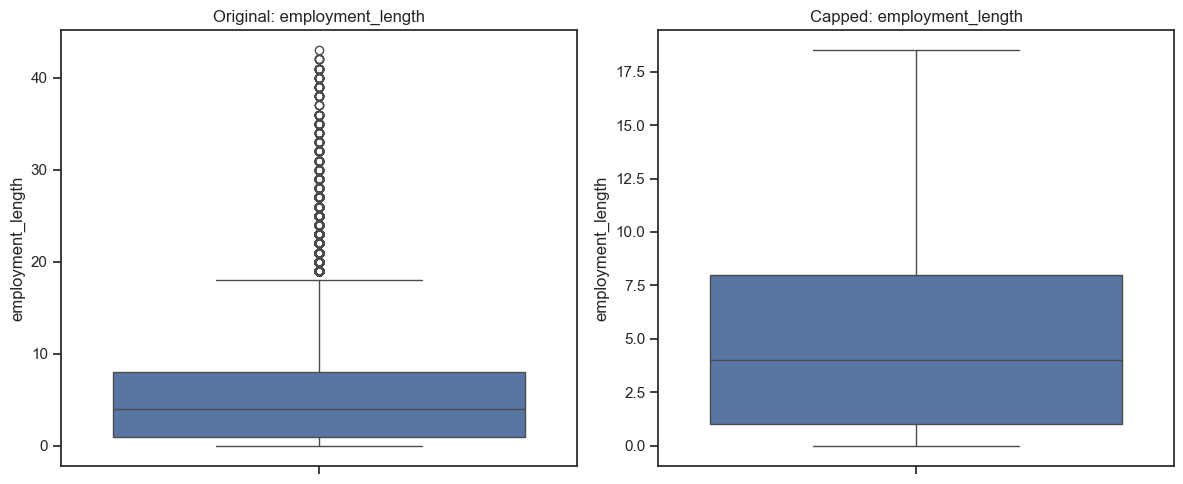

In [34]:
# Get columns with outliers (where count > 0)
%matplotlib inline
columns_with_outliers = outlier_counts[outlier_counts['outlier_count'] > 0].index.tolist()

for col in columns_with_outliers:
    plot_outlier_distributions(cleaned_df, capped_df, col)

## Correlations & Hypothesis Testing (CHI-SQUARE & ANOVA)

- This section uses Chi-Square Test to test if a categorical column has a relation with is_high_risk label while also presenting visualizations to explore how each feature is distributed across risky and non-risky customers.

In [35]:
# Step 1: Run batch chi-square test
cat_cols = capped_df.select_dtypes(include='object').columns.tolist()
chi_summary = chi_square_test_batch(capped_df, cat_cols, target_column='is_high_risk', plot=False)
chi_summary.sort_values('p_value')

,feature,p_value,significant
0,gender,0.0102,True
3,employment_status,0.1148,False
4,education_level,0.2536,False
2,own_property,0.3094,False
5,married_status,0.4002,False
6,dwelling,0.5896,False
1,own_car,0.9537,False


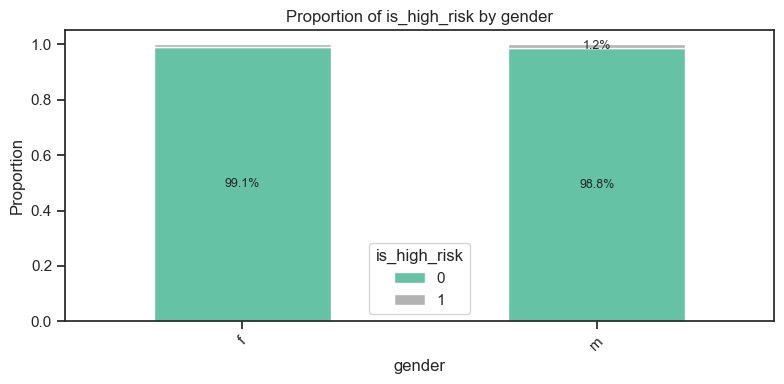

In [36]:
# Step 1b: Dynamically select significant features (excluding is_high_risk itself)
%matplotlib inline
significant_features = chi_summary[
    (chi_summary['significant'] == True) &
    (chi_summary['feature'] != 'is_high_risk')
]['feature'].tolist()

# Step 3: Plot proportions
plot_significant_categorical_proportions(capped_df, significant_features, target_column='is_high_risk')

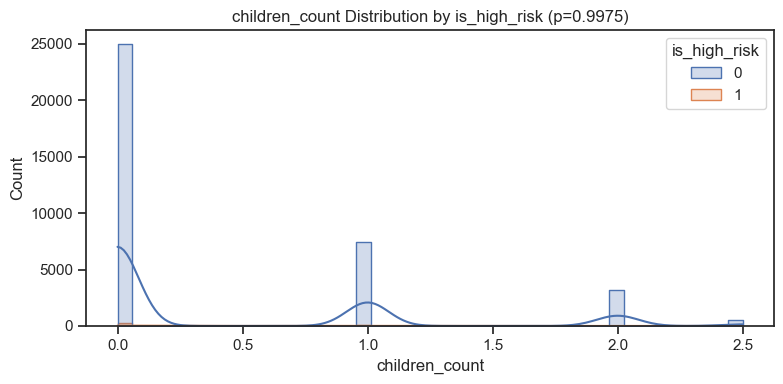

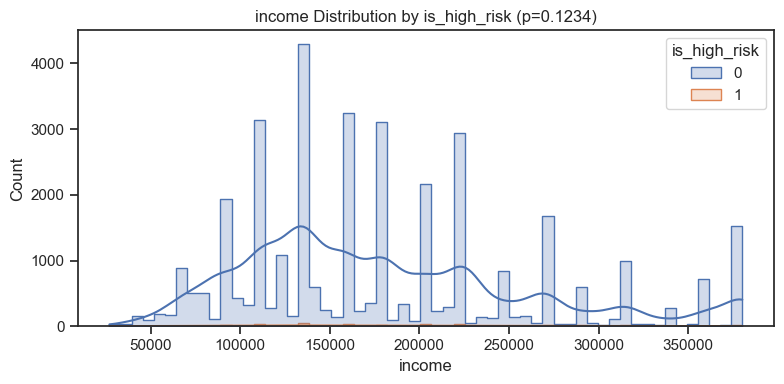

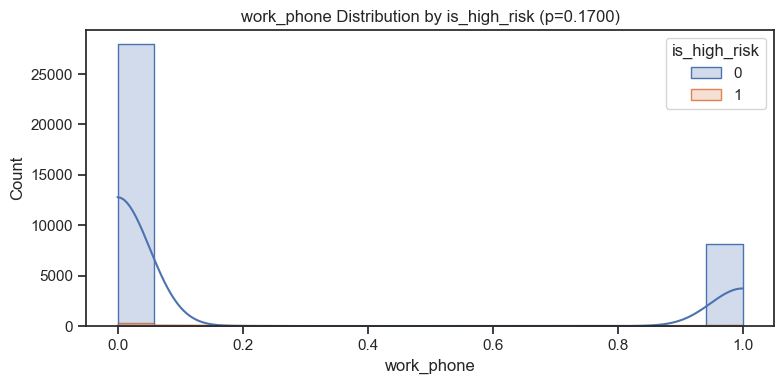

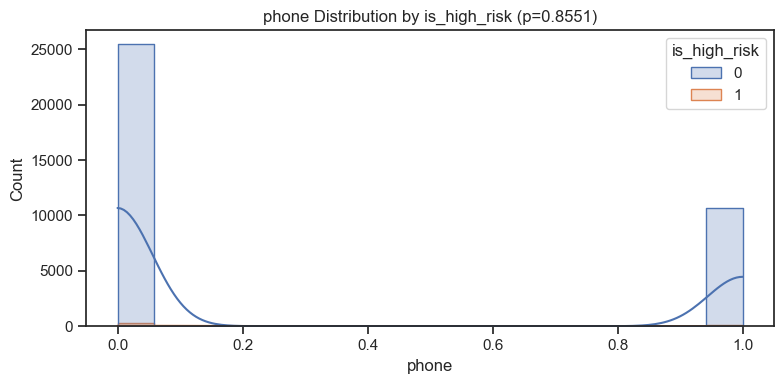

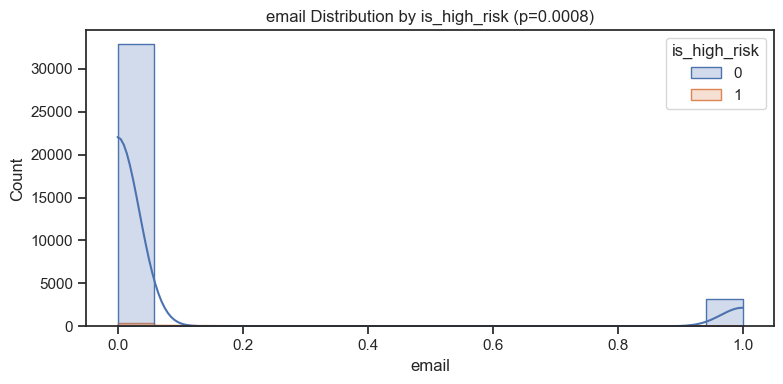

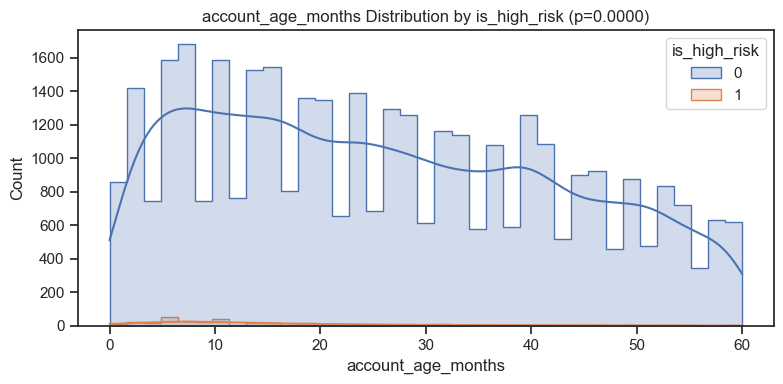

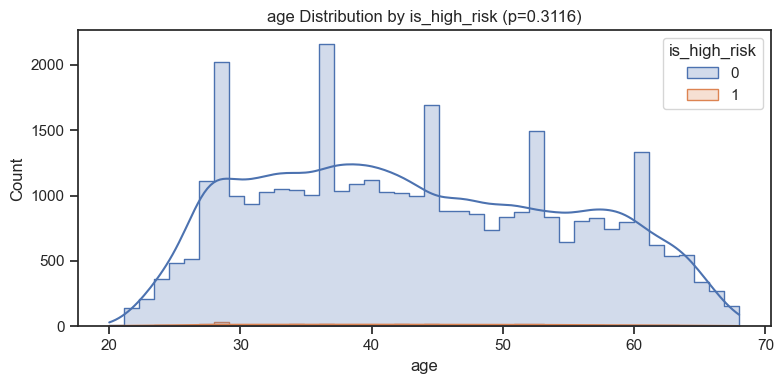

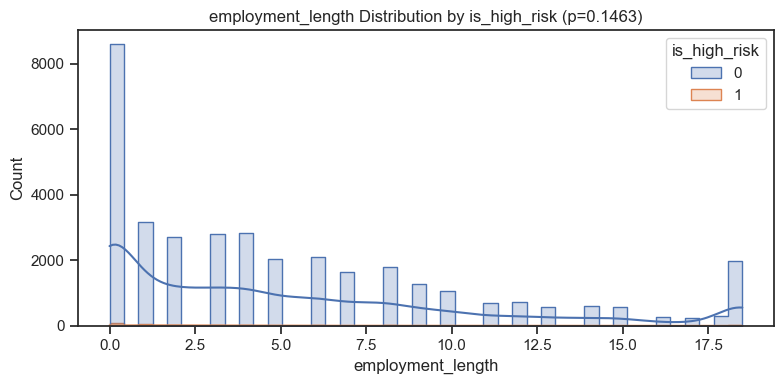

,feature,p_value,significant
5,account_age_months,0.0000,True
4,email,0.0008,True
1,income,0.1234,False
7,employment_length,0.1463,False
2,work_phone,0.1700,False
6,age,0.3116,False
3,phone,0.8551,False
0,children_count,0.9975,False


In [37]:
#Step 2: ANOVA test
%matplotlib inline
anova_results = anova_test_numerical_features(capped_df, target_column='is_high_risk', plot=True)
anova_results.sort_values('p_value')

## Prepare capped data for modelling (Feature Engineering)

**Steps:**
- Feature Relevance Analysis
- Feature Engineering
    > - Drop feature : `account_age_months`
    > - Transform skewed features (log/Box-Cox): `age` `income`
    > - One-hot Encode (multi-category columns): `married_status` `dwelling` `employment_status`
    > - Ordinal encode (binary columns): `gender`  `own_car` `own_property` `work_phone` `phone` `email`
    > - Encode target column if it's not numeric (LabelEncoder)   

### Feature Relevance Analysis

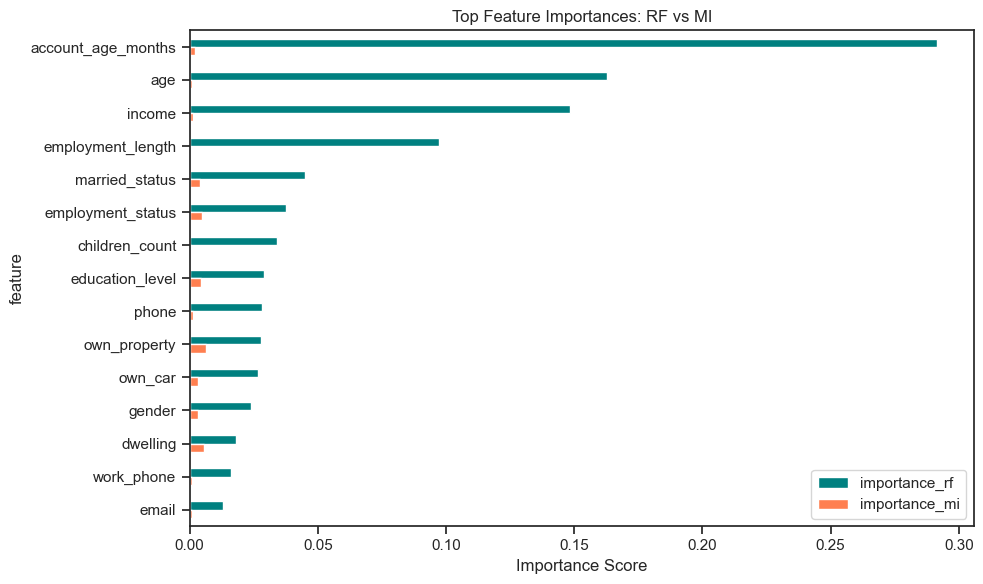

In [38]:
# feature importance
importance_df = compute_combined_feature_importance(capped_df, target_column='is_high_risk', top_n=15, plot=True)
#print(importance_df)

### Combined Insights from Feature Importance (RF vs MI) and Statistical Significance (p-values)


✅ **Significant & Predictive Features (Keep)**

These features are both **statistically significant (p < 0.05)** and have **high RF importance**:

| Feature              | Reason for Retention                             |
| -------------------- | ------------------------------------------------ |
| `account_age_months` | Most important feature (RF), p = 0.000  will be dropped because it was used to create the target variable, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.  |
| `email`              | Significant (p = 0.0008), modest RF              |
| `gender`             | Statistically significant (p = 0.0102), minor RF (e.g., females more/less likely flagged) |

---

⚠️ **Predictive But Not Statistically Significant**

Features with **strong RF importance** but **p > 0.05**:

| Feature             | Insight                                               |
| ------------------- | ----------------------------------------------------- |
| `age`               | High RF importance, but not statistically significant |
| `income`            | Important in RF, borderline p-value (0.12)            |
| `employment_length` | Relevant in RF, p = 0.14                              |

**Interpretation:** These may have **non-linear or interaction effects**, justifying retention in ML models even if not individually significant.

---

❌ **Weak and Non-significant (Consider Dropping)**

Features that are **low in RF importance** and **not statistically significant**:

| Feature           | p-value | RF Importance | Action |
| ----------------- | ------- | ------------- | ------ |
| `phone`           | 0.8551  | Low           | Drop   |
| `children_count`  | 0.9975  | Low           | Drop   |
| `work_phone`      | 0.17    | Low           | Drop   |
| `own_car`         | 0.9537  | Low           | Drop   |
| `dwelling`        | 0.5896  | Low           | Drop   |
| `own_property`    | 0.3094  | Low           | Drop   |
| `education_level` | 0.2536  | Low           | Drop   |
| `married_status`  | 0.4002  | Low           | Drop   |

---

**Final Recommendation**
- **Keep (Strong candidates)**: `age`, `income`, `employment_length`, `email`, `gender`
- **Drop (Redundant or weak)**: `phone`, `work_phone`, `own_car`, `own_property`, `dwelling`, `education_level`, `married_status`, `children_count`,`account_age_months`

---
- **Typical profile of an applicant is:**
> *a Female in her early 40s, married with a partner and no child. She has been employed for 5 years with a salary of 157,500. She has completed her secondary education. She does not own a car but owns a property (a house/apartment). Her account is 26 months old.*
---

### Feature Engineering

In [39]:
# Drop low-importance features
low_importance_features = [
    'phone',
    'work_phone',
    'own_car',
    'own_property',
    'dwelling',
    'education_level',
    'married_status',
    'account_age_months',
    'children_count',
]

processed_df = capped_df.drop(columns=low_importance_features)

print(f"processed_df.shape: {processed_df.shape}")
processed_df.head(3)


processed_df.shape: (36457, 7)


,gender,income,employment_status,email,age,employment_length,is_high_risk
0,m,380250.0,working,0,32,12.0,0
1,m,380250.0,working,0,32,12.0,0
2,m,112500.0,working,0,58,3.0,0


In [41]:
# Log-transform skewed features with skew > 1
transformed_df = transform_skewed_columns(processed_df, columns=['income', 'age'], method='cbrt')
transformed_df.head(3)

,gender,income,employment_status,email,age,employment_length,is_high_risk
0,m,72.4,working,0,3.2,12.0,0
1,m,72.4,working,0,3.2,12.0,0
2,m,48.3,working,0,3.9,3.0,0


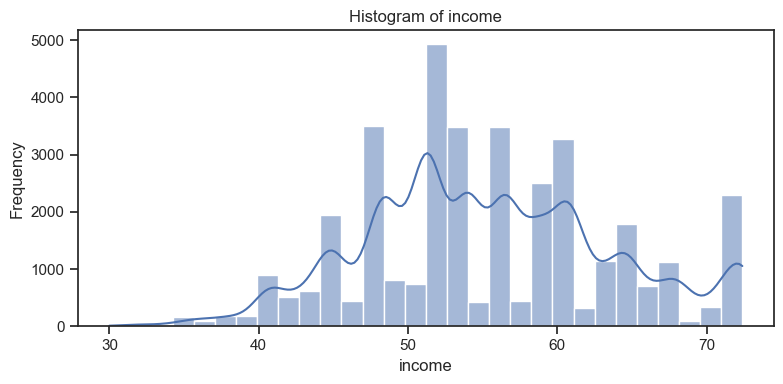

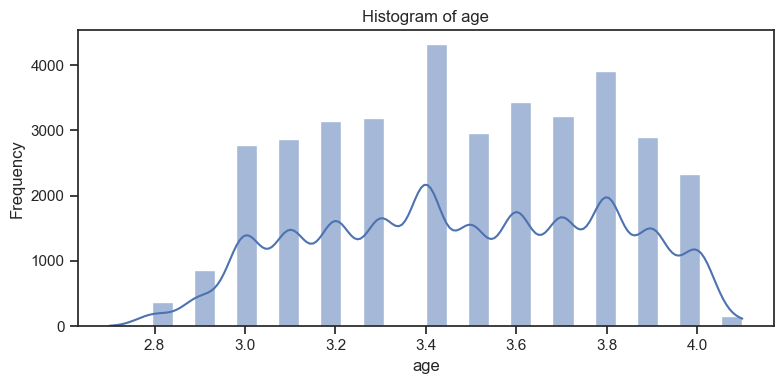

In [42]:
columns = ['income', 'age']

for col in columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=transformed_df, x=col, bins=30, kde=True)  
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [43]:
# Encoding categorical variables (binary encoding and one-hot encoding).
encoded_df = encode_columns(transformed_df, target_col='is_high_risk')
encoded_df.head(3)

,gender,income,email,age,employment_length,employment_status_pensioner,employment_status_state servant,employment_status_student,employment_status_working,is_high_risk
0,1.0,72.4,0,3.2,12.0,0.0,0.0,0.0,1.0,0
1,1.0,72.4,0,3.2,12.0,0.0,0.0,0.0,1.0,0
2,1.0,48.3,0,3.9,3.0,0.0,0.0,0.0,1.0,0


In [ ]:
'''# scale for numerical attributes
scaled_df = apply_min_max_scaling(encoded_df, target_col='is_high_risk')
scaled_df.head(3)'''

## Predictive Modeling Approach

- Scale (MinMax) and split dataset
- Balance training set using SMOTE
- Use tree-based models (Random Forest, XGBoost)
- Try logistic regression as baseline
- Optimize using AUC/recall/precision

In [44]:
# scale for numerical attributes and split df for modelling
X_train, X_test, y_train, y_test, pipeline = scale_and_split(
    encoded_df,
    target_column='is_high_risk'
)
display(X_train.shape, X_test.shape)
display(y_train.value_counts())

'''
# Get feature names from the pipeline if available
feature_names = encoded_df.drop(columns=['is_high_risk']).columns  # or however you excluded the target

# Reconstruct the DataFrame
X_train_scaled_df = pd.DataFrame(X_train, columns=feature_names)
display(X_train_scaled_df.head(3))
'''

(29165, 9)

(7292, 9)

is_high_risk
0    28859
1      306
Name: count, dtype: Int64

"\n# Get feature names from the pipeline if available\nfeature_names = encoded_df.drop(columns=['is_high_risk']).columns  # or however you excluded the target\n\n# Reconstruct the DataFrame\nX_train_scaled_df = pd.DataFrame(X_train, columns=feature_names)\ndisplay(X_train_scaled_df.head(3))\n"

### Using SMOTE to balance the classes

In [45]:
# Using SMOTE to balance the classes
X_train_resampled, y_train_resampled = balance_classes_smote(X_train, y_train)
print(y_train_resampled.value_counts())

is_high_risk
0    28859
1    28859
Name: count, dtype: Int64


In [47]:
display(X_train_resampled)

array([[0.        , 0.7       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.3       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.77299298, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.65179933, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.4       , 1.        , ..., 0.        , 0.        ,
        1.        ]])

### Post-SMOTE Modeling and Evaluation

In [ ]:
# Train baseline and other models using cross validation ==10
selected = [ "Logistic Regression","Random Forest", "XGBoost", "Gradient Boosting" ,"LightGBM", "CatBoost", "KNN","Decision Tree", "Naive Bayes", "Neural Network"]
results, trained_models =  train_and_evaluate_models(X_train_resampled, y_train_resampled, selected_models=selected)

In [ ]:
print(results['Logistic Regression']['classification_report'].keys())


In [ ]:
# Observe Metrics
summary_df = results_to_dataframe(results)
summary_df

In [ ]:
# plt model metric
%matplotlib inline
plot_model_evaluations(trained_models, X_test, y_test)

### Predictive Modeling Insights

To support the project goal of identifying **at-risk customers** during credit card approval, model selection must prioritize evaluation metrics that highlight the model’s ability to correctly flag high-risk individuals while ensuring fair decisions. 

| **Metric**           | **Why It Matters**                                                         |
| -------------------- | -------------------------------------------------------------------------- |
| **Recall**           | Captures more high-risk customers, reducing missed defaults.   it ensures the model effectively identifies those likely to default or pose financial risk — minimizing false negatives.             |
| **Precision**        | Avoids wrongly flagging reliable applicants as high-risk. avoids unnecessarily rejecting reliable applicants.                 |
| **F1 Score**         | Balances recall and precision for risk-sensitive decisions when both types of misclassification (false positives and false negatives) are costly.                |
| **ROC-AUC**          | Evaluates model performance across thresholds.                             |
| **Confusion Matrix** | Visualizes prediction breakdown — aids transparency and stakeholder trust. |

---

Since the objective of this problem is to minimize the risk of credit default for the financial institution, there is always a trade-off between precision and recall. Choosing the right metrics depends on the problem being solved. In our case, we will use recall as our metric.

✅ Best Models to Tune Compared to Logistic Regression

| **Model**    | **Recall (1)** | **F1-score (1)** | **Reason to Tune**                                                                    |
| ------------ | -------------- | ---------------- | ------------------------------------------------------------------------------------- |
| **CatBoost** | **0.99**       | **0.95**         | Highest recall with excellent F1-score — ideal for minimizing missed high-risk cases. |
| **XGBoost**  | **0.98**       | **0.93**         | Very high recall and robust F1-score — effective and widely used in credit scoring.   |

---
I'd tune and evaluate:

1. **CatBoost** — great recall + generalization + handles categorical data natively.
2. **XGBoost** — robust and tunable, with consistent high performance.

### Model Tuning using RandomizedSearchCV 

In [ ]:
#Tune selected models and save best model
models_and_params = load_models_and_params() # Load all models and params

# Pick specific models to tune
selected = ["CatBoost", "XGBoost"]
selected_models_and_params = {
    name: models_and_params[name] for name in selected
}

In [ ]:
best_model, best_name, best_scores = tune_and_select_best_model(
    X_train, y_train,
    models_and_params=selected_models_and_params,
    save_path="cc_approval_risk_best_model.joblib"
)

### Recommend Data-Driven Strategies to Reduce Risk

In [ ]:
# Load the best saved risk model
best_model = joblib.load("cc_approval_risk_best_model.joblib")
tn, fp, fn, tp = sum(results[best_name]['confusion_matrix'], [])

print(f" Best Model: {best_name}")
print(f"""
Actionable Insights (Credit Card Approval Risk Prediction):

-Approve low-risk customers confidently (TN): {tn} 
  → These applicants are correctly identified as low-risk. Proceed with approval and standard onboarding procedures.

- Block high-risk applications effectively (TP): {tp} 
  → These customers are correctly flagged as high-risk. Decline or route for manual review and risk mitigation..

- Address approval errors (FN): {fn}
  → These customers were high-risk but not flagged. Investigate additional risk signals or consider model retraining to reduce approval of defaulters.

- Minimize unnecessary rejections (FP): {fp}
  → These applicants were wrongly flagged as high-risk. Optimize threshold or feature selection to prevent rejecting creditworthy applicants.
""")


In [ ]:
import ml_pipeline_utils 
from ml_pipeline_utils import *
# Reload the module to ensure all changes are reflected
import importlib
importlib.reload(ml_pipeline_utils)


In [ ]:
import streamlit as st
import eda
import prediction

page = st.sidebar.selectbox('Pilih Halaman', ('EDA', 'Prediction'))

if page=='EDA':
    eda.run()
else:
    prediction.run()

In [ ]:
import streamlit as st
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

def run():

    #Membuat judul
    st.title('Credit Card Analysis and Prediction')

    image = Image.open('credit_card.jpeg')
    st.image(image, caption='Credit Card')

    st.markdown('------')

    #Sub judul untuk Exploratory Data Analysis
    st.subheader('Exploratory Data Analysis Credit Card')

    #Memanggil dataset
    credit_card_data = pd.read_csv('P1G5_Set_1_Christopher.csv')
    credit_card_data

    st.write("#### Penggunaan Credit Card berdasarkan Age")
    fig = plt.figure(figsize=(20, 15))
    sns.countplot(credit_card_data, x="age")
    st.pyplot(fig)

    st.write("#### Limit Balance menurut Education Level")
    limit_by_education = credit_card_data.groupby('education_level')['limit_balance'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.bar(limit_by_education.education_level, limit_by_education.limit_balance, label=limit_by_education.limit_balance)

    ax.set_ylabel('Education Level')
    ax.set_title('Limit Balance')
    ax.legend(title='Limit Balance menurut Education Level')
    st.pyplot(fig, ax)

    st.write("#### Limit Balance menurut Age")
    limit_by_age = credit_card_data.groupby('age')['limit_balance'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.bar(limit_by_age.age, limit_by_age.limit_balance)

    ax.set_ylabel('Education Level')
    ax.set_title('Limit Balance')
    ax.legend(title='Limit Balance menurut Education Level')
    st.pyplot(fig, ax)

if __name__ == "__main__":
    run()

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import pickle
from sklearn import *

with open('best_models_knc.pkl', 'rb') as file_3:
  knc_model = pickle.load(file_3)

with open('best_models_svc.pkl', 'rb') as file_6:
  svc_model = pickle.load(file_6)

with open('best_models_logreg.pkl', 'rb') as file_7:
  logreg_model = pickle.load(file_7)

def run():
    st.title('Prediction Credit Card Default or Not')

    with st.form('form_credit_card'):
       limit_balance = st.slider('Limit Balance', min_value = 0, max_value = 500000, value = 150000, help='Slide limit balance anda')
       pay_amt_1 = st.slider('Input Payment 1', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment pertama anda')
       pay_amt_2 = st.slider('Input Payment 2', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment kedua anda')
       pay_amt_3 = st.slider('Input Payment 3', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment ketiga anda')
       pay_amt_4 = st.slider('Input Payment 4', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment keempat anda')
       pay_amt_5 = st.slider('Input Payment 5', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment kelima anda')
       pay_amt_6 = st.slider('Input Payment 6', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment keenam anda')
       education_level = st.slider('Education Level', min_value = 0, max_value = 6, value = 3, help='Slide education level anda')
       pay_0 = st.slider('Input Payment 1', min_value = -2, max_value = 9, value = 3, help='Slide status payment pertama anda')
       pay_2 = st.slider('Input Payment 2', min_value = -2, max_value = 9, value = 3, help='Slide status payment kedua anda')
       pay_3 = st.slider('Input Payment 3', min_value = -2, max_value = 9, value = 3, help='Slide status payment ketiga anda')
       pay_4 = st.slider('Input Payment 4', min_value = -2, max_value = 9, value = 3, help='Slide status payment keempat anda')
       pay_5 = st.slider('Input Payment 5', min_value = -2, max_value = 9, value = 3, help='Slide status payment kelima anda')
       pay_6 = st.slider('Input Payment 6', min_value = -2, max_value = 9, value = 3, help='Slide status payment keenam anda')
       bill_amt_1 = st.slider('Input Jumlah Tagihan 1', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan pertama anda')
       bill_amt_2 = st.slider('Input Jumlah Tagihan 2', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan kedua anda')
       bill_amt_3 = st.slider('Input Jumlah Tagihan 3', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan ketiga anda')
       bill_amt_4 = st.slider('Input Jumlah Tagihan 4', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan keempat anda')
       bill_amt_5 = st.slider('Input Jumlah Tagihan 5', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan kelima anda')
       bill_amt_6 = st.slider('Input Jumlah Tagihan 6', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah tagihan keenam anda')

       #submit button
       submitted = st.form_submit_button('Predict')

    data_inf = {
    "limit_balance"  :               limit_balance,
    "pay_amt_1"      :                pay_amt_1,
    "pay_amt_2"      :                pay_amt_2,
    "pay_amt_3"      :                pay_amt_3,
    "pay_amt_4"      :                pay_amt_4,
    "pay_amt_5"      :                pay_amt_5,
    "pay_amt_6"      :                pay_amt_6,
    "education_level":          education_level,
    "pay_0"          :                   pay_0,
    "pay_2"          :                   pay_2,
    "pay_3"          :                   pay_3,
    "pay_4"          :                   pay_4,
    "pay_5"          :                   pay_5,
    "pay_6"          :                   pay_6,
    "bill_amt_1"     :               bill_amt_1,
    "bill_amt_2"     :               bill_amt_2,
    "bill_amt_3"     :               bill_amt_3,
    "bill_amt_4"     :               bill_amt_4,
    "bill_amt_5"     :               bill_amt_5,
    "bill_amt_6"     :               bill_amt_6
    }       

    data_inf = pd.DataFrame([data_inf])
    data_inf

    if submitted:

        y_pred_inf = logreg_model.predict(data_inf)
        y_pred_inf

        st.write('### Default Payment Next Month: ', str(int(y_pred_inf)))


if __name__ == "__main__":
    run()